In [443]:
#### libraries
import numpy as np
# np.seterr(all='raise') # raise errors, don't just print warnings
from numpy import *
from numpy.linalg import eig
from numpy.random import normal
from scipy.optimize import curve_fit, least_squares
from random import random as rand



#### local files
from utilities.physconsts import *
from utilities.rbconsts import *
from utilities.rbensemble import RbEnsemble as ensemble
from matplotlib import pyplot as plt



In [690]:
# a test with 50 uK atoms
factor = 1
w0 = 2.5e-6 * factor # [m]
TFORT = 1.5e-3 * factor # [K]
Tatom = 5e-5 #* factor# [K]
steps = 10
tlist = linspace(0,160,steps) # time [us
lmda = 1.064e-6 * factor
wx = w0
wy = wx


umax = kB*TFORT #times factor

zR = pi*wx**2/lmda
zRFactor = factor

omega_r = (1/sqrt((wx**2+wy**2)/2))*sqrt(2*kB*TFORT/mRb) # radial trap frequency

omega_z = (1/zR)*sqrt(2*kB*TFORT/mRb) # axial trap frequency

omega_r_unfactored = omega_r*sqrt(factor)
print(omega_z, omega_z*sqrt(factor))
# ww = lambda z: (1+z**2/zR**2)
# U = lambda x, y, z: -umax*exp(-2*x**2/(wx**2*ww(z))-2*y**2/(wy**2*ww(z)))/ww(z) 
event_ct = 200000


29274.954787835315 29274.954787835315


In [691]:
def U(x,y,z):
    ww = (1+z**2/zR**2)
    return -umax*exp(-2*x**2/(wx**2*ww)-2*y**2/(wy**2*ww))/ww

In [692]:
def xdist(T, events,plane=None):
        T *= 1e-6
        """ position component distributions """
        # Grainger group method
        omega_r
        omega_z
        
        dx = dy = sqrt(kB*T/(mRb*omega_r**2))
        dx
        dz = sqrt(kB*T/(mRb*omega_z**2))
        zlist = normal(0,dz,size=events)
        xlist = normal(0,dx,size=events)
        ylist = normal(0,dy,size=events)
        # print(xlist)
        if plane == 'xz':
            return xlist,zlist
        else:
            return xlist,ylist,zlist

In [568]:
U(*xdist(50,2000))

array([-1.89406502e-26, -1.90832908e-26, -1.88342745e-26, ...,
       -2.04618604e-26, -1.71606201e-26, -1.97216434e-26])

In [569]:
 def vdist(T, events):
        """ maxwell boltzmann speeds """
        atoms = ensemble(T)
        T *= 1e-6
        vlist = atoms.sampling_maxboltzv(events,[0,2]) # speeds

        vxlist = empty(events)
        vylist = empty(events)
        vzlist = empty(events)
        
        for i in range(events):
            ex = 2*rand()-1
            ey = 2*rand()-1
            ez = 2*rand()-1
            v = vlist[i]
            A = sqrt(ex**2+ey**2+ez**2)
            vxlist[i] = ex*v/A
            vylist[i] = ey*v/A
            vzlist[i] = ez*v/A
            
#         vlist = array([sqrt(vx**2+vy**2+vx**2) for vx,vy,vz in zip(vxlist,vylist,vzlist)])
#         plt.hist(vlist, 50, density=True) # show maxwell boltzmann speed dist
#         plt.xlabel('v')
#         plt.ylabel('occurences')
#         plt.show()

        return vxlist,vylist,vzlist



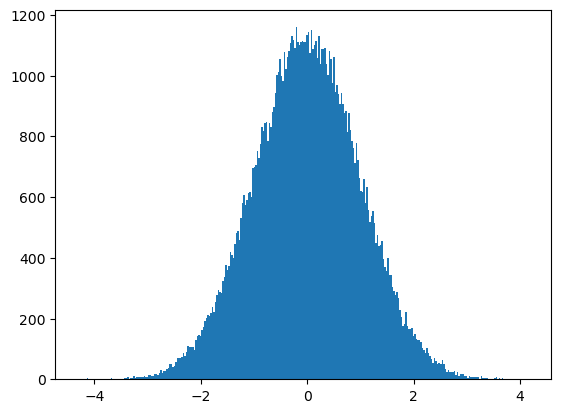

[ 1.12878418e+01 -1.89981923e-02  1.99917287e+00 -2.12095093e-03]


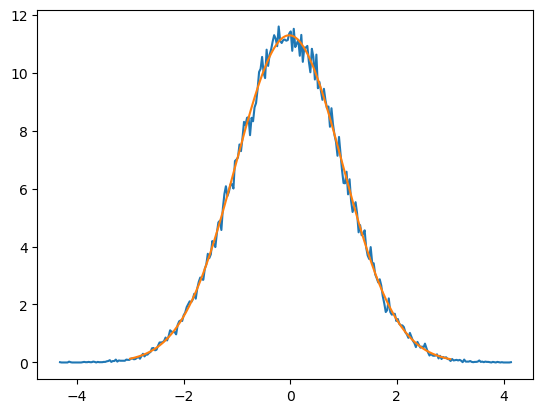

In [926]:
init_guess = (100,30,10,33000)

upper_bounds = [10000,40,100,40000]
lower_bounds = [100,5,2,10000]

def model(x, a, x0, w0, b):
    return a*np.exp(-2*((x-x0)/w0)**2) + b

xdata = np.linspace(-3, 3,100000)
ydata = normal(size = len(xdata))
count, bins, ignored = plt.hist(ydata, bins = 300)
plt.show()
count/=100
bins = bins[0:300]
plt.plot(bins,count)
popt,pcov = curve_fit(model,bins,count)

print(popt)
plt.plot(xdata,model(xdata,*popt))

In [693]:
def distplot(T,events, atoms=True, sx=1.5, sz=1.5, color="bone"):
        """ show atoms in FORT in z = 0 plane before drop and recapture """
        mu = 1e-6
        print(f"zr={zR/mu:.0f} [um], wx={wx/mu:.0f} [um]")
        
        xlist,ylist = xdist(T=T,events=events,plane='xz') # positions in [m]
        
        xpts = linspace(-sx*wx,sx*wx,100)
        zpts = linspace(-sz*zR,sz*zR,100)
        xx,zz = meshgrid(xpts,zpts)
        fpts = -U(xx,0,zz) # the fort intensity eval'd on the meshgrid
        
        cmap = plt.cm.get_cmap(color)
        
        plt.contourf(xpts/mu,zpts/mu,fpts, cmap=cmap)
        if atoms is True: # otherwise, just a dipole trap plot  
            plt.scatter(xlist/mu,ylist/mu,color='red')
        plt.xlabel("x")
        plt.ylabel("z")
#         plt.axes().set_aspect('equal')
        plt.show() 


In [866]:
def drop_recap(tlist,T=None,events=None,base_retention=None, Tdepth = None,
            progress=False, b = 1, c = 0):
        """ Procedure for simulating a release ("drop") and recapture experiment
            to deduce the temperature of actual atoms in such an experiment. 
        
            Based on code by Mark, with some corrections
            'wx': waist
            'Tdepth': FORT temperature depth
            'T': atom temp
            'tmax': max time in units us
            'steps': number of FORT drop outs
            'events': number of release-recapture events per data pt
            'wy': optional waist for eliptical FORT 
        """
        zR = pi*wx**2/lmda
        
        tlist = 1e-6*tlist
    
        if events is None:
            events = 2000
        if base_retention is None:
            base_retention = 1 # the retention baseline with no fort drop

        retention = empty(len(tlist))
        
        xlist,ylist,zlist = xdist(T,events)
        vzlist,vxlist,vylist = vdist(T,events)
        print(xlist)
        g_scaled = g*1e3
        for j,t in enumerate(tlist):

            escape = 0 
            nhot = 0 # this is an untrapped atom
            
            for i in range(events):     
                hot = 0
                KE = .5*mRb*((vxlist[i]-g*t)**2+vylist[i]**2
                              +vzlist[i]**2)
                PE0 = U(xlist[i],ylist[i],zlist[i])
                PE = U(xlist[i]+t*vxlist[i]+.5*g*(t)**2,
                       ylist[i]+t*vylist[i],
                       zlist[i]+t*vzlist[i])

                if KE + PE0 > 0:
                    hot = 1
                nhot += hot
                if KE + PE > 0:
                    escape += 1-hot
            retention[j] = base_retention*(1 - escape/events)
            
            if progress is not False:
                if j % 10 == 0:
                    print(f"timestep {j}: t = {t*1e6:.0f} [us], ret = {retention[j]:.2f}")

        retention = (retention*b - c)
        tlist*=1e6
        plt.plot(tlist,retention,label=f'{T/1e-6:.0f} uK') # show time in units [us]
#         plt.xlabel("time [us]")
#         plt.ylabel("retention")
#         plt.ylim((0,1))
#         plt.legend()
#         plt.show()        

        
        print(f"finished. T={T*1e6} [uK], r = {base_retention}")
        return tlist, retention

In [846]:
def retention_at_t_2(t, T=None, events=None, base_retention=None,
                   progress=False, t_target = 0, Tdepth = None,lmda = None, wx = None, wy = None ):
        """ Procedure for simulating a release ("drop") and recapture experiment
            to deduce the temperature of actual atoms in such an experiment.

            Based on code by Mark, with some corrections
            'wx': waist
            'Tdepth': FORT temperature depth
            'T': atom temp
            'tmax': max time in units us
            'steps': number of FORT drop outs
            'events': number of release-recapture events per data pt
            'wy': optional waist for eliptical FORT
        """
        if wy is None:
            wy = wx
        
        umax = kB*Tdepth
        zR = pi*wx**2/lmda
        
        omega_r = (1/sqrt((wx**2+wy**2)/2))*sqrt(2*kB*TFORT/mRb) # radial trap frequency

        omega_z = (1/zR)*sqrt(2*kB*TFORT/mRb) # axial trap frequency

        
        # Tdepth = Tdepth
        def U(x,y,z):
            ww = (1+z**2/zR**2)
            return -umax*exp(-2*x**2/(wx**2*ww)-2*y**2/(wy**2*ww))/ww
            
        
        dx = dy = sqrt(kB*T/(mRb*omega_r**2))
        dx
        dz = sqrt(kB*T/(mRb*omega_z**2))            
        zlist = normal(0,dz,size=events)        
        xlist = normal(0,dx,size=events)
        ylist = normal(0,dy,size=events)


        atoms = ensemble(T)
            
        vlist = atoms.sampling_maxboltzv(events,[0,2]) # speeds
    
        vxlist = empty(events)
        vylist = empty(events)
        vzlist = empty(events)
            
        for i in range(events):
            ex = 2*rand()-1                
            ey = 2*rand()-1
            ez = 2*rand()-1
            v = vlist[i]
            A = sqrt(ex**2+ey**2+ez**2)
            vxlist[i] = ex*v/A
            vylist[i] = ey*v/A
            vzlist[i] = ez*v/A
            #print(f"A:{i}::",A)
        
        
    
        # t = t*1e-6

        if events is None:
            events = 2000
        if base_retention is None:
            base_retention = 1  # the retention baseline with no fort drop
        

        #xlist, ylist, zlist = xdist(T,events)
        #vzlist, vxlist, vylist = vdist(T,events)
        # print(xlist)
        escape = 0
        nhot = 0  # this is an untrapped atom

        for i in range(events):
            hot = 0
            KE = .5 * mRb * ((vxlist[i] - g * t) ** 2 + vylist[i] ** 2
                             + vzlist[i] ** 2)
            PE0 = U(xlist[i], ylist[i], zlist[i])
            PE = U(xlist[i] + t * vxlist[i] + .5 * g * (t) ** 2,
                        ylist[i] + t * vylist[i],
                        zlist[i] + t * vzlist[i])

            
            # print(f"t = {t}")

            hot = 1*(KE + PE0 > 0)
            nhot += hot
            escape = (1 - hot)*(KE + PE > 0)

        retention = base_retention * (1 - escape / events)




        

        print(f"finished. T={T * 1e6} [uK], r = {base_retention}")
        return retention



In [1013]:
def retention_at_t_3(t, T=None,base_retention=None,c = 0, b = 1, events = 2000):
        """ Procedure for simulating a release ("drop") and recapture experiment
            to deduce the temperature of actual atoms in such an experiment.

            Based on code by Mark, with some corrections
            'wx': waist
            'Tdepth': FORT temperature depth
            'T': atom temp
            'tmax': max time in units us
            'steps': number of FORT drop outs
            'events': number of release-recapture events per data pt
            'wy': optional waist for eliptical FORT
        """
        factor = 1
        w0 = 2.5e-6 * factor # [m]
        Tdepth = 1.5e-3 * factor # [K]
        Tatom = 5e-5 #* factor# [K]
        steps = 10
        tlist = linspace(0,160,steps) # time [us
        lmda = 1.064e-6 * factor
        wx = w0
        wy = wx
        
        
        umax = kB*Tdepth
        zR = pi*wx**2/lmda
        
        omega_r = (1/sqrt((wx**2+wy**2)/2))*sqrt(2*kB*TFORT/mRb) # radial trap frequency

        omega_z = (1/zR)*sqrt(2*kB*TFORT/mRb) # axial trap frequency

        
    
        
        # Tdepth = Tdepth
        def U(x,y,z):
            ww = (1+z**2/zR**2)
            return -umax*exp(-2*x**2/(wx**2*ww)-2*y**2/(wy**2*ww))/ww
            
        
        dx = dy = sqrt(kB*T/(mRb*omega_r**2))
        dx
        dz = sqrt(kB*T/(mRb*omega_z**2))            
        zlist = normal(0,dz,size=events)        
        xlist = normal(0,dx,size=events)
        ylist = normal(0,dy,size=events)


        atoms = ensemble(T)
            
        vlist = atoms.sampling_maxboltzv(events,[0,2]) # speeds
    
        vxlist = empty(events)
        vylist = empty(events)
        vzlist = empty(events)
            
        for i in range(events):
            ex = 2*rand()-1                
            ey = 2*rand()-1
            ez = 2*rand()-1
            v = vlist[i]
            A = sqrt(ex**2+ey**2+ez**2)
            vxlist[i] = ex*v/A
            vylist[i] = ey*v/A
            vzlist[i] = ez*v/A
            #print(f"A:{i}::",A)
        
        
    
        t = t*1e-6

        if events is None:
            events = 2000
        if base_retention is None:
            base_retention = 1  # the retention baseline with no fort drop
        

        #xlist, ylist, zlist = xdist(T,events)
        #vzlist, vxlist, vylist = vdist(T,events)
        # print(xlist)
        escape = np.empty(len(t))
        nhot = 0  # this is an untrapped atom

        for i in range(events):
            hot = 0
            KE = .5 * mRb * ((vxlist[i] - g * t) ** 2 + vylist[i] ** 2
                             + vzlist[i] ** 2)
            PE0 = U(xlist[i], ylist[i], zlist[i])
            PE = U(xlist[i] + t * vxlist[i] + .5 * g * (t) ** 2,
                        ylist[i] + t * vylist[i],
                        zlist[i] + t * vzlist[i])

            
            # print(f"t = {t}")
            #print(KE+PE0)
            
            init_E = KE + PE0
            hot_E = KE + PE
            #print(init_E)
            #print(np.greater(hot_E,0))
            escape+=np.greater(hot_E,0)
            #print(escape)
            #print("\n\n\n\n",hot_E)
            #print(init_E > 0)
            #if KE + PE0 > 0:
            #    hot = 1
            #nhot += hot
            #if KE + PE > 0:
            #    escape += 1-hot
            
            
            #if KE + PE > 0:
            #    escape += 1-hot
                
        retention = base_retention * (1 - escape / events)




        

        print(f"finished. T={T * 1e6} [uK], r = {base_retention}, b = {b}, c = {c}")
        #print(b,c,retention,t)
        return b*retention-c



In [1014]:
TLIST = linspace(0,120,10) # time [us]
R1 = retention_at_t_3(TLIST, 5e-5, base_retention = 0.9, events = 2000)
print(R1)

5e-05
1.3807e-23
5e-05
1.4192261e-25
1
finished. T=50.0 [uK], r = 0.9, b = 1, c = 0
[0.9     0.8757  0.64305 0.42885 0.28935 0.20655 0.15165 0.1179  0.09315
 0.0801 ]


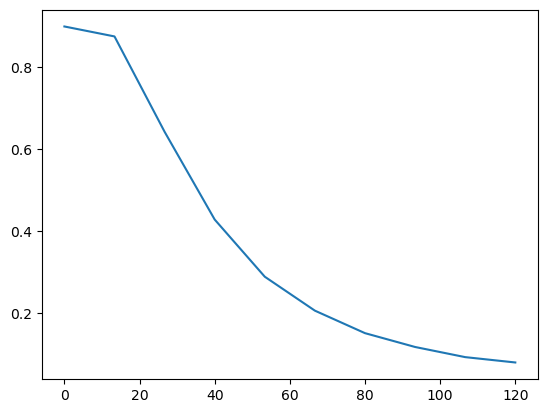

In [1015]:
plt.plot(TLIST,R1)

In [848]:
def retention_at_t(t, T=None, events=None, base_retention=None,
                   progress=False, Tdepth = None,):
        """ Procedure for simulating a release ("drop") and recapture experiment
            to deduce the temperature of actual atoms in such an experiment.

            Based on code by Mark, with some corrections
            'wx': waist
            'Tdepth': FORT temperature depth
            'T': atom temp
            'tmax': max time in units us
            'steps': number of FORT drop outs
            'events': number of release-recapture events per data pt
            'wy': optional waist for eliptical FORT
        """
        
        # Tdepth = Tdepth
        def U(x,y,z):
            ww = (1+z**2/zR**2)
            return -umax*exp(-2*x**2/(wx**2*ww)-2*y**2/(wy**2*ww))/ww
        def xdist(T, events,plane=None):
            """ position component distributions """
            # Grainger group method
            omega_r
            omega_z
            
            dx = dy = sqrt(kB*T/(mRb*omega_r**2))
            dx
            dz = sqrt(kB*T/(mRb*omega_z**2))
            zlist = normal(0,dz,size=events)
            xlist = normal(0,dx,size=events)
            ylist = normal(0,dy,size=events)
            # print(xlist)
            if plane == 'xz':
                return xlist,zlist
            else:
                return xlist,ylist,zlist
        
        def vdist(T, events):
            """ maxwell boltzmann speeds """
            #atoms = ensemble(T)
            
            #vlist = atoms.sampling_maxboltzv(events,[0,2]) # speeds
    
            vxlist = empty(events)
            vylist = empty(events)
            vzlist = empty(events)
            
            for i in range(events):
                ex = 2*rand()-1
                ey = 2*rand()-1
                ez = 2*rand()-1
                v = vlist[i]
                A = sqrt(ex**2+ey**2+ez**2)
                vxlist[i] = ex*v/A
                vylist[i] = ey*v/A
                vzlist[i] = ez*v/A
                
    #         vlist = array([sqrt(vx**2+vy**2+vx**2) for vx,vy,vz in zip(vxlist,vylist,vzlist)])
    #         plt.hist(vlist, 50, density=True) # show maxwell boltzmann speed dist
    #         plt.xlabel('v')
    #         plt.ylabel('occurences')
    #         plt.show()

            return vxlist,vylist,vzlist
    
        t = t*1e-6

        if events is None:
            events = 2000
        if base_retention is None:
            base_retention = 1  # the retention baseline with no fort drop
        

        xlist, ylist, zlist = xdist(T,events)
        vzlist, vxlist, vylist = vdist(T,events)
        # print(xlist)
        escape = 0
        nhot = 0  # this is an untrapped atom

        for i in range(events):
            hot = 0
            KE = .5 * mRb * ((vxlist[i] - g * t) ** 2 + vylist[i] ** 2
                             + vzlist[i] ** 2)
            PE0 = U(xlist[i], ylist[i], zlist[i])
            PE = U(xlist[i] + t * vxlist[i] + .5 * g * (t) ** 2,
                        ylist[i] + t * vylist[i],
                        zlist[i] + t * vzlist[i])

            
            # print(f"t = {t}")

            hot = 1*(KE + PE0 > 0)
            nhot += hot
            escape = (1 - hot)*(KE + PE > 0)

        retention = base_retention * (1 - escape / events)        

        print(f"finished. T={T * 1e6} [uK], r = {base_retention}")
        return retention

In [849]:
def run_drop(tlist, Tatom):
    rlist = retention_at_t(tlist, T=Tatom, base_retention=0.9, Tdepth = TFORT, events = event_ct)
    #rlist = drop_recap(tlist, T=Tatom, base_retention = 0.9)
    return np.log(rlist)

In [850]:
def run_drop_3(tlist, Tatom, base_retention):
    # print(Tatom)
    rlist = retention_at_t_2(tlist, T=Tatom, base_retention=base_retention, Tdepth = TFORT, events = event_ct, wx = wx, lmda = lmda,)
    #rlist = drop_recap(tlist, T=Tatom, base_retention = 0.9)
    return rlist


In [851]:
def run_drop_2(t,Tatom, wx1, Tdepth1):
    rlist = retention_at_t_2(t, T=Tatom, events=event_ct, base_retention=0.9,
                   progress=True, Tdepth = Tdepth1,lmda = lmda, wx = wx1, wy = None )
    return rlist
def run_drop_4(t,Tatom, wx1, Tdepth1, base_retention):
    rlist = retention_at_t_2(t, T=Tatom, events=event_ct, base_retention=base_retention,
                   progress=True, Tdepth = Tdepth1,lmda = lmda, wx = wx1, wy = None )
    return rlist

In [852]:
def run_drop_log_params(x, log_T_0,):
    """
    Model for Bcd gradient: exponential decay plus 
    background with log parameters.
    """
    
    # Exponentiate parameters
    T_0 = np.exp(log_T_0)
    
    return run_drop(x, T_0)
    

In [853]:
Tatom = 5e-5


In [781]:
Tatom = 60

zr=18 [um], wx=3 [um]


C:\Users\Rb\AppData\Local\Temp\ipykernel_11904\2143103330.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(color)


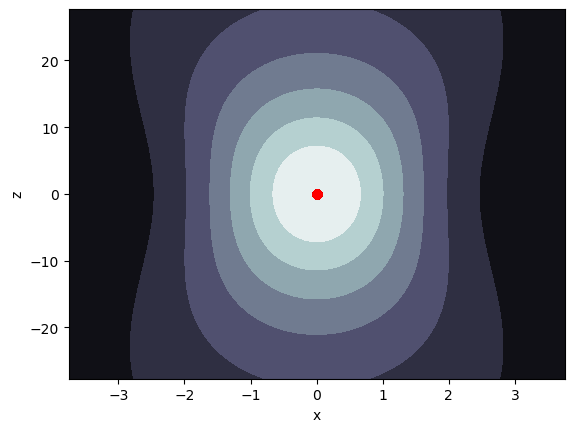

5e-05
1.3807e-23
5e-05
1.4192261e-25
1
[ 2.61759424e-10  1.67069744e-10 -9.76513345e-11 ...  4.09603184e-10
 -5.83150098e-11  7.15136713e-11]
finished. T=50.0 [uK], r = 0.9
5e-05
1.3807e-23
5e-05
1.4192261e-25
1
finished. T=50.0 [uK], r = 0.9, b = 1, c = 0


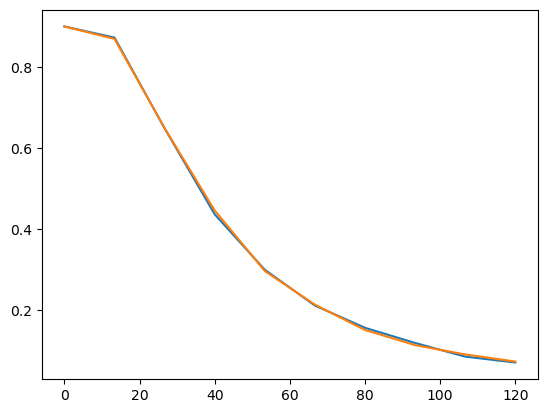

In [1018]:
distplot(Tatom, events = event_ct)
tlist = linspace(0,120,10) # time [us]
TLIST = linspace(0,120,10) # time [us]
tlist, r1 = drop_recap(tlist, Tatom, base_retention = 0.9, events = 2000)
R1 = retention_at_t_3(TLIST, Tatom, base_retention = 0.9)
plt.plot(TLIST,R1)

In [1009]:
print(type(tlist[0]))

<class 'numpy.float64'>


In [ ]:
t_data = array([0.0, 2.0, 4.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 
                20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 140.0, 160.0])
ret_data = [0.92079207920792083, 0.94999999999999996, 0.93000000000000005, 
            0.89000000000000001, 0.93999999999999995, 0.90000000000000002, 
            0.93999999999999995, 0.84999999999999998, 0.85999999999999999, 
            0.81000000000000005, 0.67000000000000004, 0.39000000000000001, 
            0.28712871287128711, 0.27000000000000002, 0.16, 0.10000000000000001, 
            0.089999999999999997]
factor = 1
lower_bound = [1e-5*factor]
upper_bound = [9e-5*factor]


popt, pcov, infodict, msg, ier = curve_fit(retention_at_t_3, t_data, ret_data, p0 = [4e-5, 0.95], absolute_sigma=True, maxfev = 1000000000, full_output = True)



4e-05
1.3807e-23
4e-05
1.4192261e-25
1
finished. T=40.0 [uK], r = 0.95, b = 1, c = 0
4.000000059604645e-05
1.3807e-23
4.000000059604645e-05
1.4192261e-25
1
finished. T=40.00000059604645 [uK], r = 0.95, b = 1, c = 0
4e-05
1.3807e-23
4e-05
1.4192261e-25
1
finished. T=40.0 [uK], r = 0.9500000141561031, b = 1, c = 0
nan
1.3807e-23
nan
1.4192261e-25
1


In [872]:
print(type(retention_at_t_3(15, T=50,base_retention=0.9)))

50
1.3807e-23
50
1.4192261e-25
1


KeyboardInterrupt: 

In [873]:
print(popt)
print(pcov)
print(infodict)
print(msg)
print(ier)

[ 4.59348356e-03  9.38437366e-01 -2.29668395e+02 -2.44331947e+02]
[[inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]
 [inf inf inf inf]]
{'fvec': array([-0.5218335, -0.4989735, -0.2686185, -0.0526635,  0.0885015,
        0.1721115,  0.2275515,  0.2626965,  0.2870865,  0.3041415]), 'nfev': 32, 'fjac': array([[ 7.72645461e+02,  3.16227766e-01,  3.16227766e-01,
         3.16227766e-01,  3.16227766e-01,  3.16227766e-01,
         3.16227766e-01,  3.16227766e-01,  3.16227766e-01,
         3.16227766e-01],
       [ 0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 3.16227767e+00,  0.00000000e+00, -0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-2.96759892e+00,  0.00000000e+00,  0.00000000e+00,
        -0.00000000e+00,

0.004593483564483624
1.3807e-23
0.004593483564483624
1.4192261e-25
1
[-8.29917415e-10 -2.02382134e-09  7.74859854e-10 ...  2.90808891e-09
  1.02563610e-09  2.55006633e-09]
timestep 0: t = 0 [us], ret = 0.94
finished. T=4593.483564483624 [uK], r = 0.9384373663748592
[28.80254289 52.83407143 53.92249492 54.10569491 54.21345962 54.24578903
 54.26734197 54.2565655  54.24578903 54.24578903]


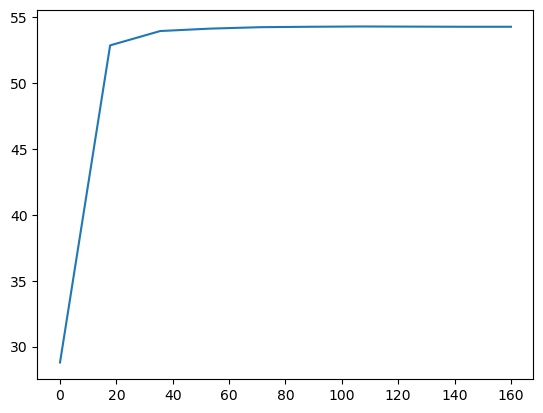

In [874]:
Topt = popt[0]
ropt = popt[1]
bopt = popt[2]
copt = popt[3]
tlist2 = np.linspace(0,160,10)
tlist2, ret2 = drop_recap(tlist2,T=(Topt),base_retention=ropt, b=bopt, c= copt, Tdepth = TFORT,
            progress=True, events = 20000)
print(ret2)

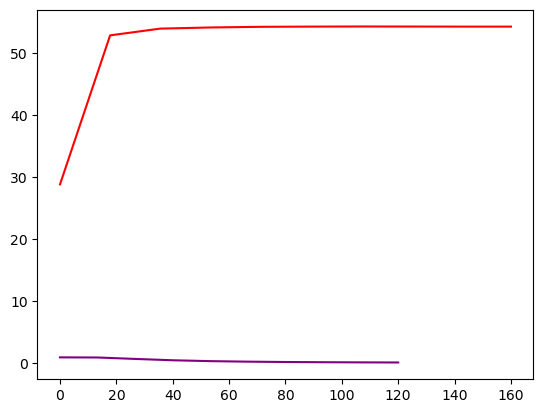

In [875]:
#tlist3, ret3 = drop_recap(tlist, T=5, base_retention=0.9, Tdepth = TFORT, progress=True, events = event_ct)
plt.plot(tlist2,ret2, color = "red") # show time in units [us]
#plt.plot(tlist3*1e6,ret3, color = "purple") # show time in units [us]
plt.plot(tlist, r1, color = "purple") # show time in units [us]
plt.show()